In [138]:
import numpy as np
def replicas(x, y, L):
    """
    Function to generate replicas of a single particle.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """    
    xr = np.zeros(9)
    yr = np.zeros(9)

    for i in range(3):
        for j in range(3):
            xr[3 * i + j] = x + (j - 1) * L
            yr[3 * i + j] = y + (i - 1) * L
    
    return xr, yr

In [139]:
def pbc(x, y, L):
    """
    Function to enforce periodic boundary conditions on the positions.
    
    Parameters
    ==========
    x, y : Position.
    L : Side of the squared arena.
    """   
    
    outside_left = np.where(x < - L / 2)[0]
    x[outside_left] = x[outside_left] + L

    outside_right = np.where(x > L / 2)[0]
    x[outside_right] = x[outside_right] - L

    outside_up = np.where(y > L / 2)[0]
    y[outside_up] = y[outside_up] - L

    outside_down = np.where(y < - L / 2)[0]
    y[outside_down] = y[outside_down] + L
    
    return x, y

In [140]:
def remove_overlap(x, y, R, L, dl, N_max_iter):
    """
    Function to remove the overlap between particles.
    Use the volume exclusion methods.
    If N_max_iter iterations are reached, then it stops.
    
    Parameters
    ==========
    x, y : Positions.
    R : Particle radius.
    L : Dimension of the squared arena.
    dl : Tolerance on the overlap. Must be much smaller than R.
    N_max_iter : stops if the number of iterations is larger than this.
    """

    N_part = np.size(x)
    step = 0
    running = True
    
    while running:
        
        n_overlaps = 0
        
        for i in np.arange(N_part):
            for j in np.arange(i + 1, N_part):                
                # Check overlap.
                dx = x[j] - x[i]
                dy = y[j] - y[i]
                dist = np.sqrt(dx ** 2 + dy ** 2)
                
                if dist < 2 * R - dl:
                    n_overlaps += 1  # Increment overlap counter.
                    # Remove overlap.
                    xm = 0.5 * (x[j] + x[i]) 
                    ym = 0.5 * (y[j] + y[i]) 
                    x[i] = xm - dx / dist * R
                    y[i] = ym - dy / dist * R
                    x[j] = xm + dx / dist * R
                    y[j] = ym + dy / dist * R
                
        step += 1
        
        if (step >= N_max_iter) or (n_overlaps == 0):
            running = False
    
    x, y = pbc(x, y, L)  # Apply periodic boundary conditions.

    return x, y     


In [141]:
from functools import reduce

def phoretic_velocity(x, y, R, v0, r_c, L):
    """
    Function to calculate the phoretic velocity.
    
    Parameters
    ==========
    x, y : Positions.
    R : Particle radius.
    v0 : Phoretic reference velocity.
    r_c : Cut-off radius.
    L : Dimension of the squared arena.
    """
    
    N = np.size(x)

    vx = np.zeros(N)  # Phoretic velocity (x component).
    vy = np.zeros(N)  # Phoretic velocity (y component).
    
    # Preselect what particles are closer than r_c to the boundaries.
    replicas_needed = reduce( 
        np.union1d, (
            np.where(y + r_c > L / 2)[0], 
            np.where(y - r_c < - L / 2)[0],
            np.where(x + r_c > L / 2)[0],
            np.where(x - r_c > - L / 2)[0]
        )
    )

    for j in range(N - 1):   
        
        # Check if replicas are needed to find the interacting neighbours.
        if np.size(np.where(replicas_needed == j)[0]):
            # Use replicas.
            xr, yr = replicas(x[j], y[j], L)
            for nr in range(9):
                dist2 = (x[j + 1:] - xr[nr]) ** 2 + (y[j + 1:] - yr[nr]) ** 2 
                nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
                
                # The list of nearest neighbours is set.
                # Contains only the particles with index > j
        
                if np.size(nn) > 0:
                    nn = nn.astype(int)
        
                    # Find interaction
                    dx = x[nn] - xr[nr]
                    dy = y[nn] - yr[nr]
                    dist = np.sqrt(dx ** 2 + dy ** 2)
                    v_p = v0 * R ** 2 / dist ** 2
                    dvx = dx / dist * v_p
                    dvy = dy / dist * v_p
            
                    # Contribution for particle j.
                    vx[j] += np.sum(dvx)
                    vy[j] += np.sum(dvy)

                    # Contribution for nn of particle j nr replica.
                    vx[nn] -= dvx
                    vy[nn] -= dvy
                
        else:
            dist2 = (x[j + 1:] - x[j]) ** 2 + (y[j + 1:] - y[j]) ** 2 
            nn = np.where(dist2 <= r_c ** 2)[0] + j + 1
        
            # The list of nearest neighbours is set.
            # Contains only the particles with index > j
        
            if np.size(nn) > 0:
                nn = nn.astype(int)
        
                # Find interaction
                dx = x[nn] - x[j]
                dy = y[nn] - y[j]
                dist = np.sqrt(dx ** 2 + dy ** 2)
                v_p = v0 * R ** 2 / dist ** 2
                dvx = dx / dist * v_p
                dvy = dy / dist * v_p
            
                # Contribution for particle j.
                vx[j] += np.sum(dvx)
                vy[j] += np.sum(dvy)

                # Contribution for nn of particle j.
                vx[nn] -= dvx
                vy[nn] -= dvy
                   
    return vx, vy


In [142]:
import numpy as np
N_part = 200  # Number of active Brownian particles.

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient. 
gammaR = 8 * np.pi * R ** 3 * eta  # Rotational drag coefficient. 
kBT = 4.11e-21  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].
DR = kBT / gammaR  # Rotational diffusion constant [1 / s].
t_r = 1 / DR  # Orientation relaxation time.

v = 5e-6  # Self-propulsion speed [m/s].

v0 = 20e-6  # Phoretic reference speed [m/s].
r_c = 10 * R  # Cut-off radius [m].


dt = np.round((R/v0)/10,3)  # Time step [s].
print("dt=",dt)


L = 100 * R  # Side of the arena.

print(f't_r={t_r:.3f} s')

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_x = np.sqrt(2 * D * dt)
c_noise_y = np.sqrt(2 * D * dt)
c_noise_phi = np.sqrt(2 * DR * dt)


dt= 0.005
t_r=6.115 s


## Q1 


Choose dt such that the particles can not overlap. To account for this, we have to look at $v_{max} = v_0 = 20*10^{-6} m/s$ and the radius R. To be on the safe side, i also chose dt much smaller than this ratio e.g 10 times smaller. Thus $dt = \frac{\frac{R}{v_{max}}}{10}$

## P1 

Time: 0.0


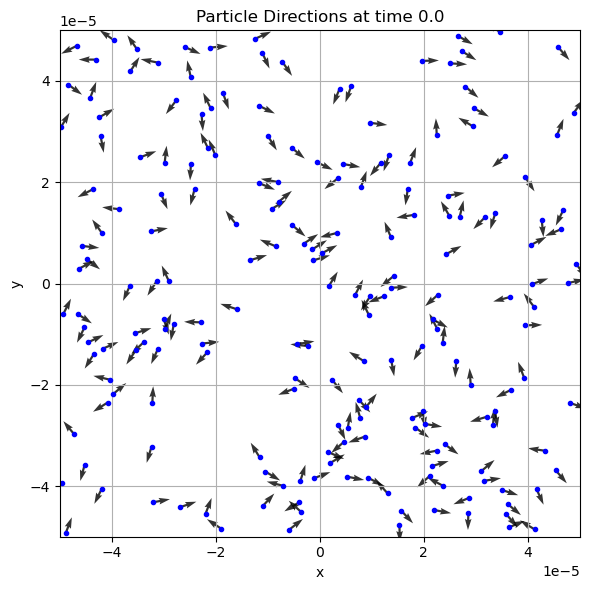

Time: 1.0
Time: 2.0
Time: 3.0
Time: 4.0
Time: 5.0


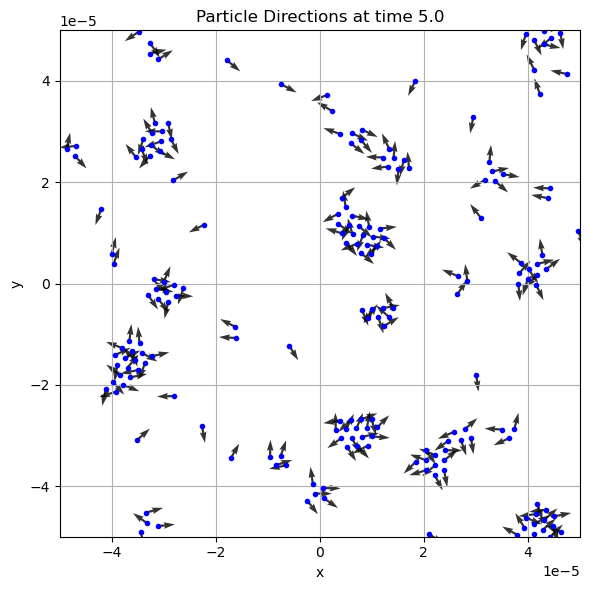

In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import matplotlib.pyplot as plt

window_size = 600

vp = 2 * R  # Length of the arrow indicating the velocity direction.
line_width = 1  # Width of the arrow line.

step = 0
duration = 50

while step*dt <= duration+1:

    # Calculate phoretic velocity.
    vp_x, vp_y = phoretic_velocity(x, y, R, v0, r_c, L)
       
    # Calculate new positions and orientations.
    nx = x + (v * np.cos(phi) + vp_x) * dt + c_noise_x * np.random.normal(0, 1, N_part)
    ny = y + (v * np.sin(phi) + vp_y) * dt + c_noise_y * np.random.normal(0, 1, N_part)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)

    # Apply pbc.
    nx, ny = pbc(nx, ny, L)
    
    # Remove overlap.
    nx, ny = remove_overlap(nx, ny, R, L, dl=1e-8, N_max_iter=20)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    t_step = step*dt
    if t_step % 1 == 0:
        print("Time:",t_step)

    if(t_step == 0 or t_step == 5 or t_step == 10 or t_step == 20 or t_step == 50):
            plt.figure(figsize=(6, 6))
            plt.plot(nx, ny, '.', color='blue', markersize = 20)
            plt.quiver(nx, ny, vp*np.cos(nphi), vp*np.sin(nphi), color='black', angles='xy', scale_units='xy', scale=0.6, alpha=0.8)
            plt.title(f'Particle Directions at time {t_step}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.xlim([-L/2,L/2])
            plt.ylim([-L/2,L/2])
            plt.tight_layout()
            plt.show()

    step += 1
    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  

## Q2 


In [ ]:
import numpy as np
N_part = 200  # Number of active Brownian particles.

R = 1e-6  # Radius of the Brownian particle [m].
eta = 1e-3  # Viscosity of the medium.
gamma = 6 * np.pi * R * eta  # Drag coefficient. 
gammaR = 8 * np.pi * R ** 3 * eta  # Rotational drag coefficient. 
kBT = 4.11e-21  # kB*T at room temperature [J].
D = kBT / gamma  # Diffusion constant [m^2 / s].
DR = kBT / gammaR  # Rotational diffusion constant [1 / s].
t_r = 1 / DR  # Orientation relaxation time.

v = 5e-6  # Self-propulsion speed [m/s].

v0 = 20e-6  # Phoretic reference speed [m/s].
r_c = 10 * R  # Cut-off radius [m].


dt = np.round((R/v0)/10,3)  # Time step [s].
print("dt=",dt)


L = 50 * R  # Side of the arena.

print(f't_r={t_r:.3f} s')

# Initialization.

# Random position.
x = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]
y = (np.random.rand(N_part) - 0.5) * L  # in [-L/2, L/2]

# Random orientation.
phi = 2 * (np.random.rand(N_part) - 0.5) * np.pi  # in [-pi, pi]

# Coefficients for the finite difference solution.
c_noise_x = np.sqrt(2 * D * dt)
c_noise_y = np.sqrt(2 * D * dt)
c_noise_phi = np.sqrt(2 * DR * dt)


In [ ]:
import time
from scipy.constants import Boltzmann as kB 
from tkinter import *
import matplotlib.pyplot as plt

window_size = 600

vp = 2 * R  # Length of the arrow indicating the velocity direction.
line_width = 1  # Width of the arrow line.

step = 0
duration = 50

while step*dt <= duration+1:

    # Calculate phoretic velocity.
    vp_x, vp_y = phoretic_velocity(x, y, R, v0, r_c, L)
       
    # Calculate new positions and orientations.
    nx = x + (v * np.cos(phi) + vp_x) * dt + c_noise_x * np.random.normal(0, 1, N_part)
    ny = y + (v * np.sin(phi) + vp_y) * dt + c_noise_y * np.random.normal(0, 1, N_part)
    nphi = phi + c_noise_phi * np.random.normal(0, 1, N_part)

    # Apply pbc.
    nx, ny = pbc(nx, ny, L)
    
    # Remove overlap.
    nx, ny = remove_overlap(nx, ny, R, L, dl=1e-8, N_max_iter=20)
    
    # Reflecting boundary conditions.
    nx, ny = pbc(nx, ny, L)

    t_step = step*dt
    if t_step % 1 == 0:
        print("Time:",t_step)

    if(t_step == 0 or t_step == 5 or t_step == 10 or t_step == 20 or t_step == 50):
            plt.figure(figsize=(6, 6))
            plt.plot(nx, ny, '.', color='blue', markersize=20)
            plt.quiver(nx, ny, vp*np.cos(nphi), vp*np.sin(nphi), color='black', angles='xy', scale_units='xy', scale=0.6, alpha=0.8)
            plt.title(f'Particle Directions at time {t_step}')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.grid()
            plt.xlim([-L/2,L/2])
            plt.ylim([-L/2,L/2])
            plt.tight_layout()
            plt.show()

    step += 1
    x[:] = nx[:]
    y[:] = ny[:]
    phi[:] = nphi[:]  